In [1]:
import torch
import sys
sys.path.extend(['..'])
from mvn import MVNIso, MVNDiag, MVNFull, create_mog
from distributions import log_prob_banana, log_prob_cigar
from samplers import stams_mvn_langevin, stams_mvn_hmc, stams_importance_sampling
from util import acf, ess
import matplotlib.pyplot as plt
import time
%matplotlib inline

Select the target distribution, family of q, and hyperparameter $\lambda_{KL}$

In [2]:
log_p = log_prob_banana
q_class = MVNIso
lambda_kl = 2.0
n_samples = 5000

Run the Langevin sampler

In [3]:
t_start = time.time()
info_mala = stams_mvn_langevin(log_p, lambda_kl, q_class.new_random(d=2), n_samples=n_samples)
t_elapsed = time.time() - t_start

print(f"Got {n_samples} samples in {t_elapsed:.2f} seconds. Acceptance ratio = {info_mala['accept']}")

Got 5000 samples in 4.05 seconds. Acceptance ratio = 0.9228000044822693


Run the HMC sampler

In [4]:
t_start = time.time()
info_hmc = stams_mvn_hmc(log_p, lambda_kl, q_class.new_random(d=2), n_samples=n_samples)
t_elapsed = time.time() - t_start

print(f"Got {n_samples} samples in {t_elapsed:.2f} seconds. Acceptance ratio = {info_hmc['accept']}")

Got 5000 samples in 165.77 seconds. Acceptance ratio = 0.8615999817848206


Run the importance sampler

Got 5000 samples in 1.83 seconds from proposal: (tensor([-0.0154,  0.0536, -0.7682]), tensor([[ 1.7717e+00, -1.6109e-03, -1.2756e-01],
        [-1.6109e-03,  3.9712e-01,  1.2240e-01],
        [-1.2756e-01,  1.2240e-01,  6.8505e-01]]))


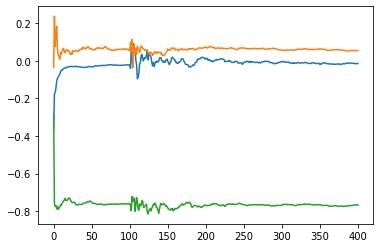

In [5]:
t_start = time.time()
info_is = stams_importance_sampling(log_p, lambda_kl, q_class.new_random(d=2), n_samples=n_samples)
t_elapsed = time.time() - t_start

print(f"Got {n_samples} samples in {t_elapsed:.2f} seconds from proposal: {info_is['proposal_mean'], info_is['proposal_cov']}")
plt.plot(info_is['th_optim'])

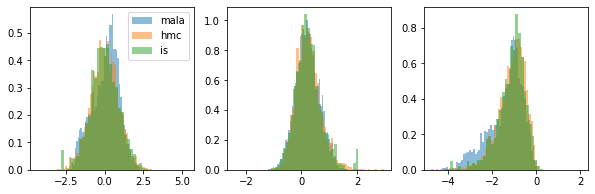

In [6]:
sz = (1, n_samples)
fig, ax = plt.subplots(1, 3, figsize=(10,3))
for i in range(3):
    ax[i].hist(info_mala['samples'][:,i].reshape(sz), density=True, bins=50, alpha=.5)
    ax[i].hist(info_hmc['samples'][:,i].reshape(sz), density=True, bins=50, alpha=.5)
    ax[i].hist(info_is['samples'][:,i].reshape(sz), weights=info_is['weights'].reshape(sz), density=True, bins=50, alpha=.5)
ax[0].legend(['mala', 'hmc', 'is'])
fig.tight_layout
plt.show()

Sanity check: do the two samplers agree on expectations of some polynomials?

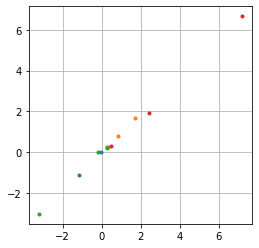

In [7]:
plt.figure(figsize=(4,4))
for degree in [1., 2., 3., 4.]:
    ev_hmc = (info_hmc['samples']**degree).mean(dim=0)
    ev_is = (info_is['samples']**degree * info_is['weights'][:,None]).sum(dim=0) / info_is['weights'].sum()
    plt.plot(ev_is, ev_hmc, marker='.', linestyle='none')
plt.grid('on')

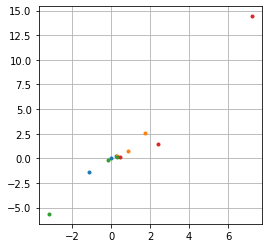

In [8]:
plt.figure(figsize=(4,4))
for degree in [1., 2., 3., 4.]:
    ev_mala = (info_mala['samples']**degree).mean(dim=0)
    ev_is = (info_is['samples']**degree * info_is['weights'][:,None]).sum(dim=0) / info_is['weights'].sum()
    plt.plot(ev_is, ev_mala, marker='.', linestyle='none')
plt.grid('on')